Transfer learning


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
transfer_model = models.resnet50(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

**freezing parameters**

In [7]:
for name, param in transfer_model.named_parameters():
  if("bn" not in name):
    param.requires_grad = False

**Replacing classifier**

In [8]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500),
                                  nn.ReLU(),
                                  nn.Dropout(), nn.Linear(500,2))

**Training model again**

In [24]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
  for epoch in range(1, epochs+1):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, targets = batch
      inputs = inputs.to(device)
      targets = targets.to(device)
      output = model(inputs)
      loss = loss_fn(output, targets)
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item() * inputs.size(0)
    training_loss /= len(train_loader.dataset)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
      inputs, targets = batch
      inputs = inputs.to(device)
      output = model(inputs)
      targets = targets.to(device)
      loss = loss_fn(output, targets)
      valid_loss += loss.data.item() * inputs.size(0)
      correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
      num_correct += torch.sum(correct).item()
      num_examples += correct.shape[0]
    valid_loss /= len(val_loader.dataset)

    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

In [20]:
def check_image(path):
  try:
    im = Image.open(path)
    return True
  except:
    return False


img_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data_path = '/content/drive/MyDrive/Colab Notebooks/images/train'

train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms, is_valid_file=check_image)

val_data_path = '/content/drive/MyDrive/Colab Notebooks/images/val'
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)
batch_size = 64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")



In [14]:
val_data

Dataset ImageFolder
    Number of datapoints: 107
    Root location: /content/drive/MyDrive/Colab Notebooks/images/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [15]:
train_data

Dataset ImageFolder
    Number of datapoints: 659
    Root location: /content/drive/MyDrive/Colab Notebooks/images/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [21]:
print(len(val_data_loader.dataset))

107


In [25]:
train(model=transfer_model, optimizer=optimizer, loss_fn=torch.nn.CrossEntropyLoss(),
      train_loader=train_data_loader, val_loader=val_data_loader, epochs=5, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 0.26, Validation Loss: 0.82, accuracy = 0.663551
Epoch: 2, Training Loss: 0.14, Validation Loss: 0.32, accuracy = 0.878505
Epoch: 3, Training Loss: 0.05, Validation Loss: 0.46, accuracy = 0.841121
Epoch: 4, Training Loss: 0.02, Validation Loss: 0.36, accuracy = 0.869159
Epoch: 5, Training Loss: 0.02, Validation Loss: 0.33, accuracy = 0.859813


LEARNING RATE FINDER

In [27]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
  number_in_epoch = len(train_loader) - 1
  update_step = (final_value / init_value) ** (1 / number_in_epoch)
  lr = init_value
  optimizer.param_groups[0]["lr"] = lr
  best_loss = 0.0
  batch_num = 0
  losses = []
  log_lrs = []
  for data in train_loader:
    batch_num += 1
    inputs, targets = data
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    if batch_num > 1 and loss > 4 * best_loss:
      if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
      else:
        return log_lrs, losses

    if loss < best_loss or batch_num == 1:
      best_loss = loss
    
    losses.append(loss.item())
    log_lrs.append((lr))

    loss.backward()
    optimizer.step()

    lr *= update_step
    optimizer.param_groups[0]["lr"] = lr
  if (len(log_lrs)>20):
    return log_lrs[10:-5], losses[10:-5]
  else:
    return log_lrs, losses











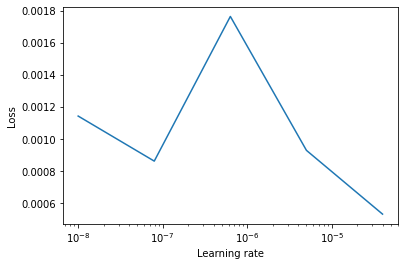

In [28]:
(lrs, losses) = find_lr(model=transfer_model, loss_fn=torch.nn.CrossEntropyLoss(),
                        optimizer=optimizer, train_loader=train_data_loader, device=device
                        )
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

**Custom transforms**

In [29]:
def _random_colour_space(x):
  output = x.convert("HSV")
  return output

In [30]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [31]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [32]:
class Noise():
  """
  """
  def __init__(self, mean, stddev):
    self.mean = mean
    self.stddev = stddev

  def __call__(self, tensor):
    noise = torch.zeros_like(tensor).normal_(self.mean, self.mean)
    return tensor.add_(noise)

  def __repr__(self) -> str:
    repr = f"{self.__class__.__name__ }(mean={self.mean}, stddev={self.stddev}"
    return repr

In [33]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

Ensemles

In [35]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1, 3, 244, 244).to(device))) for m in models_ensemble]
avg_prediction = torch.stack(predictions).mean(0).argmax()




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [36]:
avg_prediction

tensor(482)

In [37]:
torch.stack(predictions)

tensor([[[0.0005, 0.0010, 0.0005,  ..., 0.0004, 0.0012, 0.0003]],

        [[0.0011, 0.0003, 0.0006,  ..., 0.0029, 0.0003, 0.0011]]],
       grad_fn=<StackBackward0>)